# Background

Idle qubits may undergo damping and dephasing error due to T1-relaxation and T2-dephasing. Dynamical Decoupling (DD) can suppress those errors. In the simplemest terms, applying DD involves dressing the idle times between gates on a qubit with some choice of DD sequence. For example, one such sequence is called CPMG sequence that dresses idle times on a qubit with two X gates with delay before, after, and in between the X gates.

As DD is a time-dependent process, we require knowledge of timing in our quantum circuits. The basic idea for implementing DD is to schedule circuits, find the times over which qubits are idle, and replace those idle periods with gate (pulse) sequences at specific intervals that add up to the identity operation. Fortunately, Qiskit transpiler has built-in passes to do all the above-mentioned steps. We will show how to configure Qiskit's default pass manager to transform an input circuit with DD sequence. Besides, we will see that for some problems the use of DD can mean the difference between getting a signal or nothing but noise.

# Imports

In [1]:
import numpy as np
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.result import sampled_expectation_value
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator

# Dynamical decoupling imports
from qiskit.circuit.library import XGate, YGate, RZGate
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling

from qiskit_ibm_provider import IBMProvider
from qiskit.providers.fake_provider import FakeHanoiV2

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

# Setup: test circuit, simulator, and backend

Our example for showing the power of DD on today’s quantum systems comes courtesy of Lawrence Berkeley National Laboratory (LBNL) in the form of wormhole inspired teleportation: "Towards Quantum Gravity in the Lab on Quantum Processors",
*Illya Shapoval, Vincent Paul Su, Wibe de Jong, Miro Urbanek, Brian Swingle* (https://arxiv.org/abs/2205.14081).

We want to see how the teleportation protocall behaves as we vary the coupling strength $g$ 
 by evaluating the expectation value $\langle Z \rangle$ of the state at the end. To this end, we create a quantum circuit parameterized by a single variable $g$:

In [2]:
g = Parameter('g')

In [3]:
qc = QuantumCircuit(6, 1)
qc.h(0)
qc.cx(0, 5)
qc.h(1)
qc.cx(1, 4)
qc.h(2)
qc.cx(2, 3)
qc.rx(-np.pi/2, 0)
qc.rx(-np.pi/2, 1)
qc.rx(-np.pi/2, 2)
qc.rz(-0.0566794, 0)
qc.rz(-0.01039906, 1)
qc.rz(-0.0632158, 2)
qc.rzz(-np.pi/2, 0, 1)
qc.rzz(-np.pi/2, 1, 2)
qc.rx(-np.pi/2, 0)
qc.rx(-np.pi/2, 1)
qc.rx(-np.pi/2, 2)
qc.rz(-0.0566794, 0)
qc.rz(-0.01039906, 1)
qc.rz(-0.0632158, 2)
qc.rzz(-np.pi/2, 0, 1)
qc.rzz(-np.pi/2, 1, 2)
qc.rx(-np.pi/2, 0)
qc.rx(-np.pi/2, 1)
qc.rx(-np.pi/2, 2)
qc.rz(-0.0566794, 0)
qc.rz(-0.01039906, 1)
qc.rz(-0.0632158, 2)
qc.rzz(-np.pi/2, 0, 1)
qc.rzz(-np.pi/2, 1, 2)
qc.reset(0)
qc.rz(0.0566794, 0)
qc.rz(0.01039906, 1)
qc.rz(0.0632158, 2)
qc.rzz(np.pi/2, 0, 1)
qc.rzz(np.pi/2, 1, 2)
qc.rx(np.pi/2, 0)
qc.rx(np.pi/2, 1)
qc.rx(np.pi/2, 2)
qc.rz(0.0566794, 0)
qc.rz(0.01039906, 1)
qc.rz(0.0632158, 2)
qc.rzz(np.pi/2, 0, 1)
qc.rzz(np.pi/2, 1, 2)
qc.rx(np.pi/2, 0)
qc.rx(np.pi/2, 1)
qc.rx(np.pi/2, 2)
qc.rz(0.0566794, 0)
qc.rz(0.01039906, 1)
qc.rz(0.0632158, 2)
qc.rzz(np.pi/2, 0, 1)
qc.rzz(np.pi/2, 1, 2)
qc.rx(np.pi/2, 0)
qc.rx(np.pi/2, 1)
qc.rx(np.pi/2, 2)
# Here are the two RZZ gates that are parameterized
qc.rzz(g, 1, 4)
qc.rzz(g, 2, 3)
# -------------------------------------------------
qc.rx(np.pi/2, 5)
qc.rx(np.pi/2, 4)
qc.rx(np.pi/2, 3)
qc.rz(0.0566794, 5)
qc.rz(0.01039906, 4)
qc.rz(0.0632158, 3)
qc.rzz(np.pi/2, 5, 4)
qc.rzz(np.pi/2, 4, 3)
qc.rx(np.pi/2, 5)
qc.rx(np.pi/2, 4)
qc.rx(np.pi/2, 3)
qc.rz(0.0566794, 5)
qc.rz(0.01039906, 4)
qc.rz(0.0632158, 3)
qc.rzz(np.pi/2, 5, 4)
qc.rzz(np.pi/2, 4, 3)
qc.rx(np.pi/2, 5)
qc.rx(np.pi/2, 4)
qc.rx(np.pi/2, 3)
qc.rz(0.0566794, 5)
qc.rz(0.01039906, 4)
qc.rz(0.0632158, 3)
qc.rzz(np.pi/2, 5, 4)
qc.rzz(np.pi/2, 4, 3)
qc.measure(5, 0)

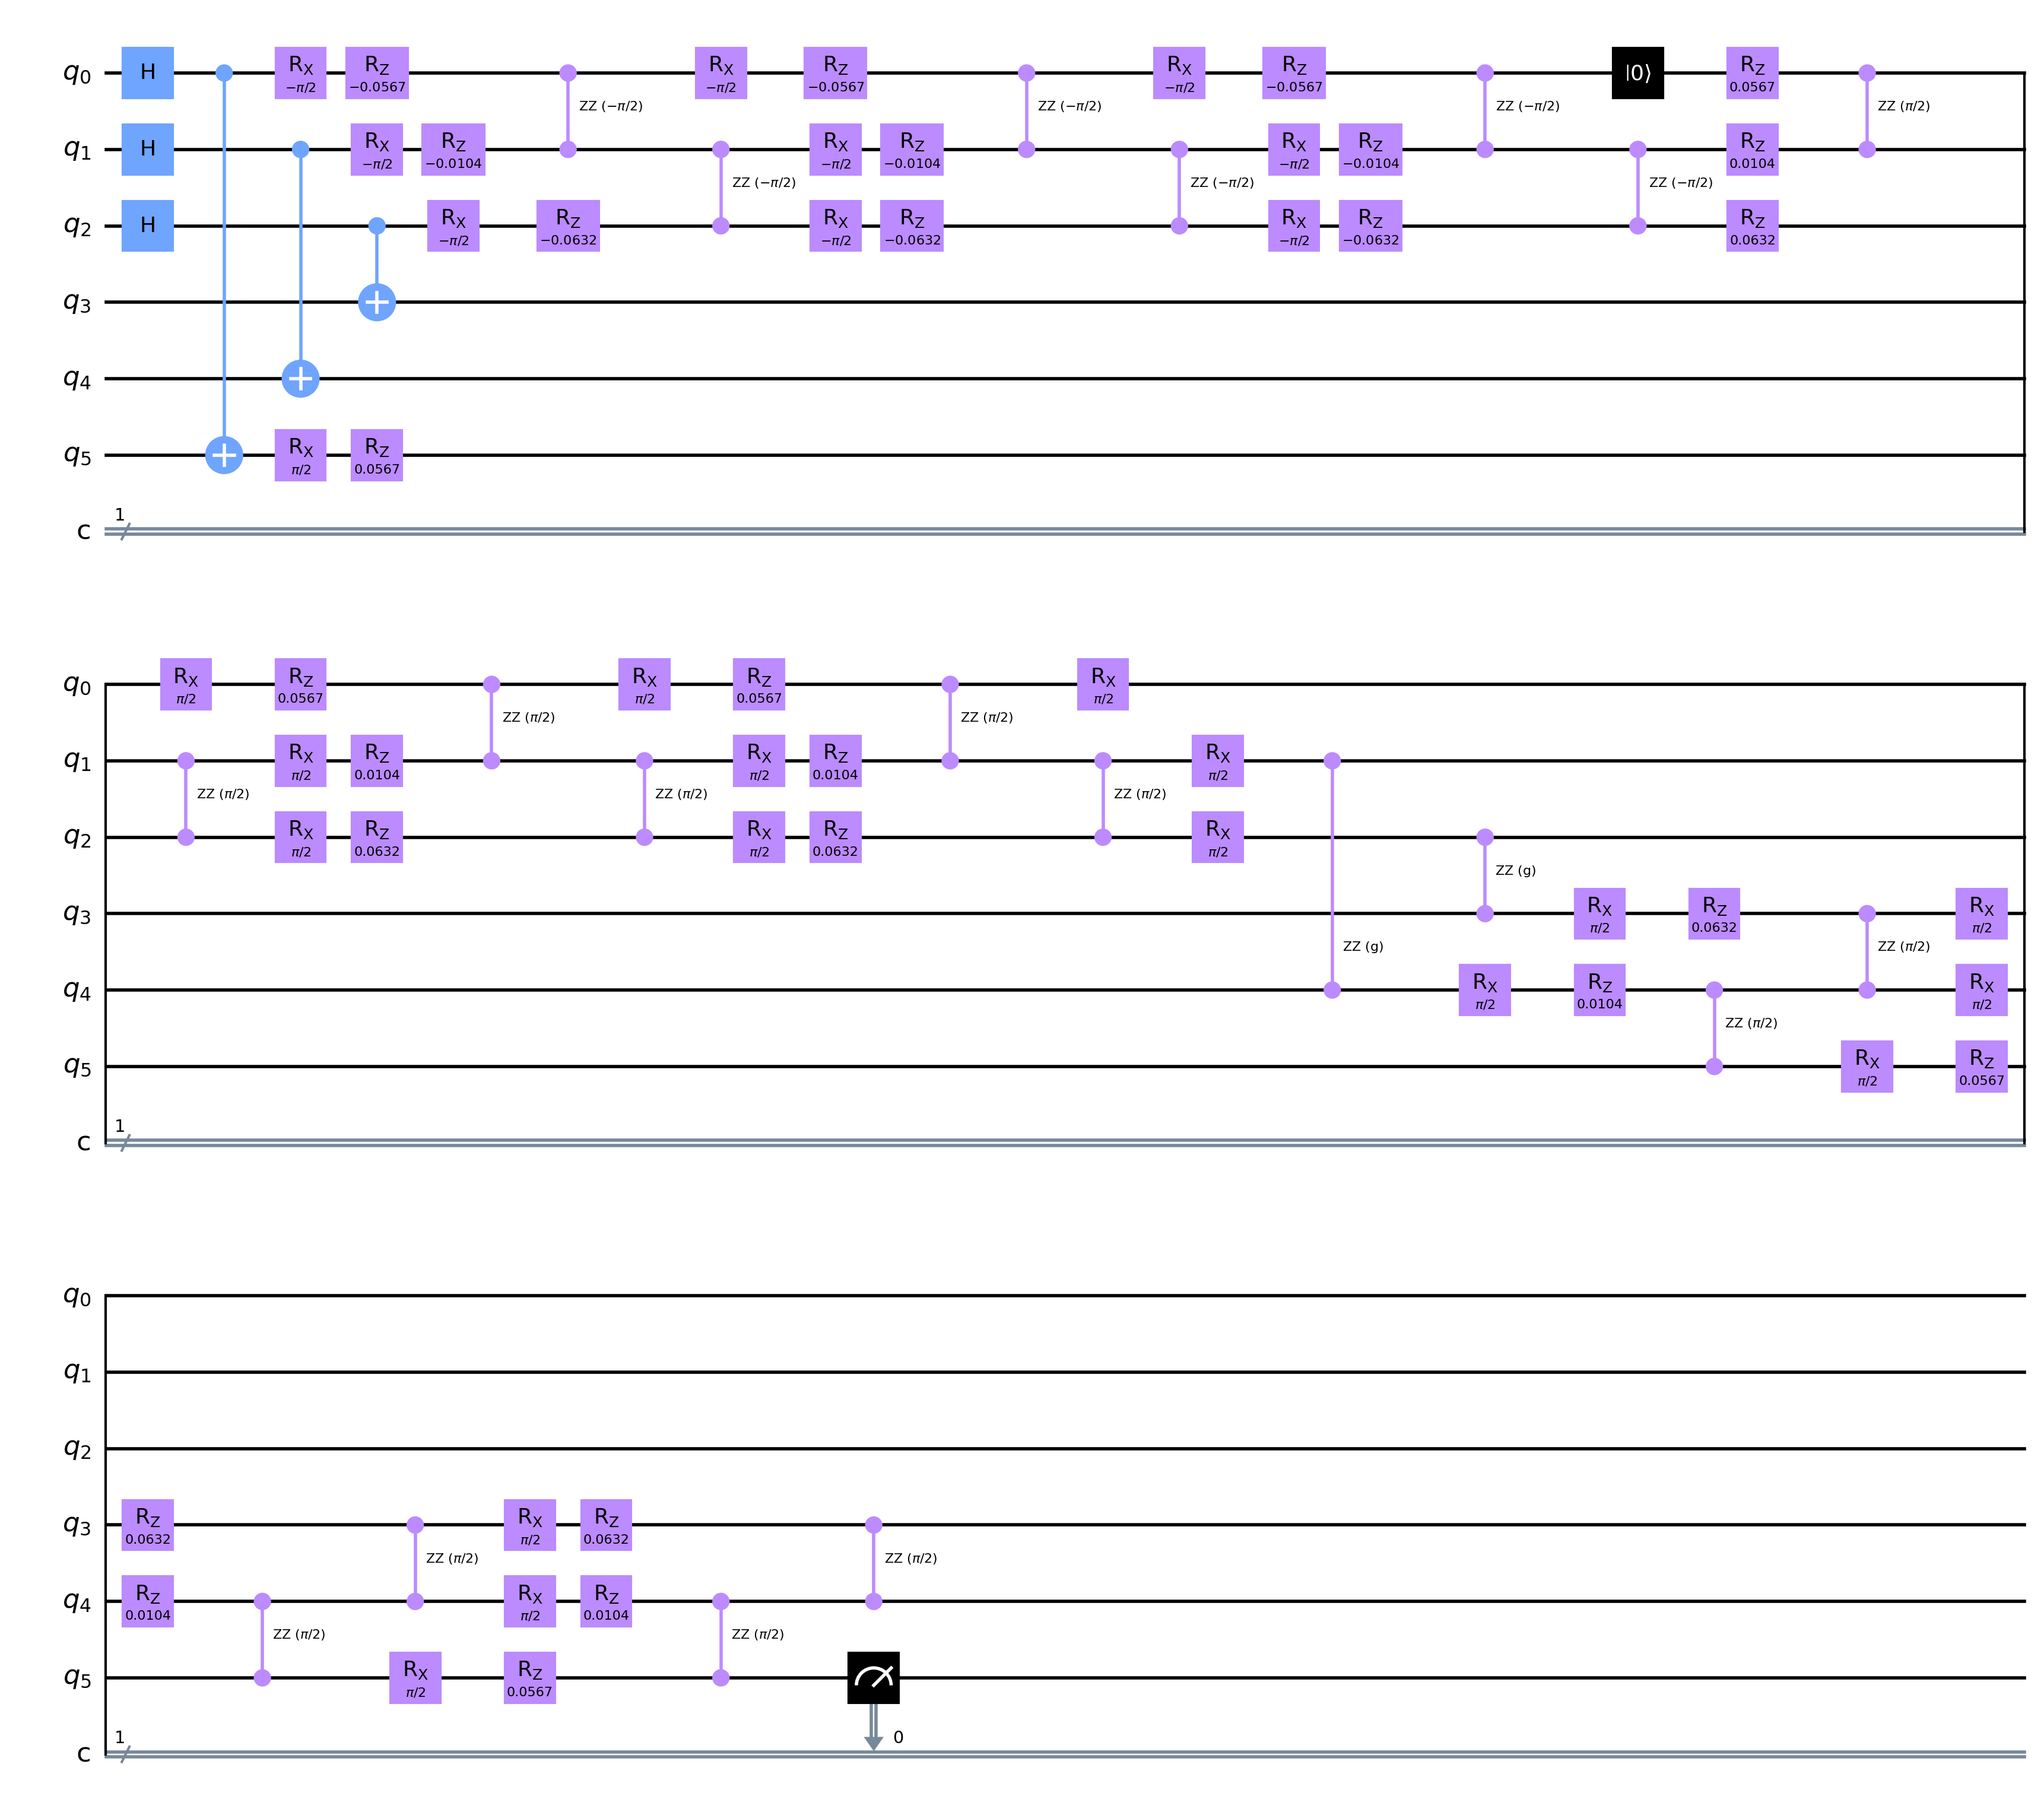

In [4]:
qc.draw("mpl")

In [5]:
operator = SparsePauliOp("Z")

In [6]:
g_vals = np.linspace(0, np.pi, 11)

ideal_circs = [qc.assign_parameters([val]) for val in g_vals]

In [7]:
sim = AerSimulator()

In [8]:
provider = IBMProvider()
backend = provider.get_backend("ibm_cusco")

In [9]:
fake_backend = FakeHanoiV2()

# Ideal simulation

In [10]:
shots = 10000
ideal_counts = sim.run(ideal_circs, shots=shots).result().get_counts()

In [11]:
ideal_expval = [sampled_expectation_value(dist=cnts, oper=operator) for cnts in ideal_counts]

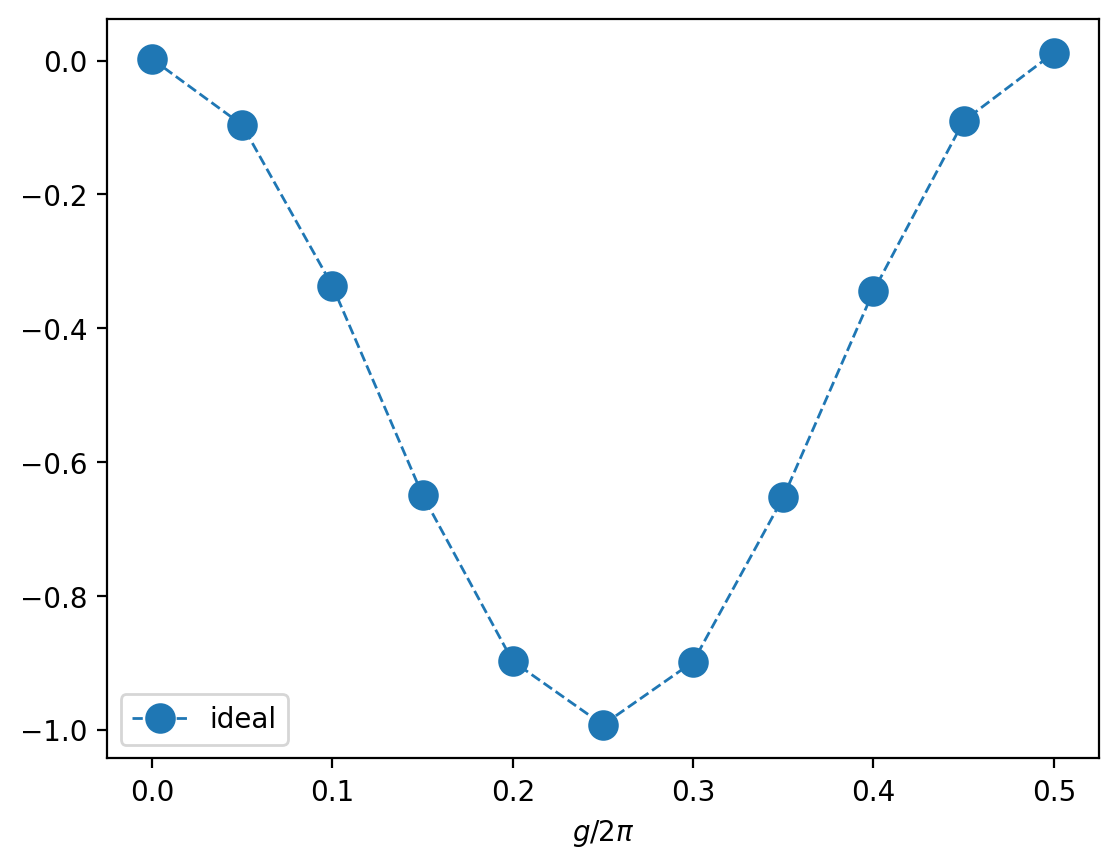

In [12]:
fig, ax = plt.subplots()
ax.plot(g_vals/(2*np.pi), ideal_expval, 'o--', ms=10, lw=1, label='ideal')
ax.legend()
ax.set_xlabel('$g/2\pi$');

# Real hardware execution

<div class="alert alert-warning">
   <div>
       <big><b>Real Hardware Run</b></big>
   </div>
   <br>
    For the sake of time, you may skip running on real backend during the workshop.
</div>

In [13]:
trans_circs = transpile(ideal_circs, backend, optimization_level=3)

/Users/haimengzhang/miniconda3/envs/runtime/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/haimengzhang/miniconda3/envs/runtime/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/haimengzhang/miniconda3/envs/runtime/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/haimengzhang/miniconda3/envs/runtime/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/haimengzhang/miniconda3/envs/runtime/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/U

In [13]:
real_counts = backend.run(trans_circs, shots=shots).result().get_counts()

In [14]:
real_expval = [sampled_expectation_value(cnts, 'Z') for cnts in real_counts]

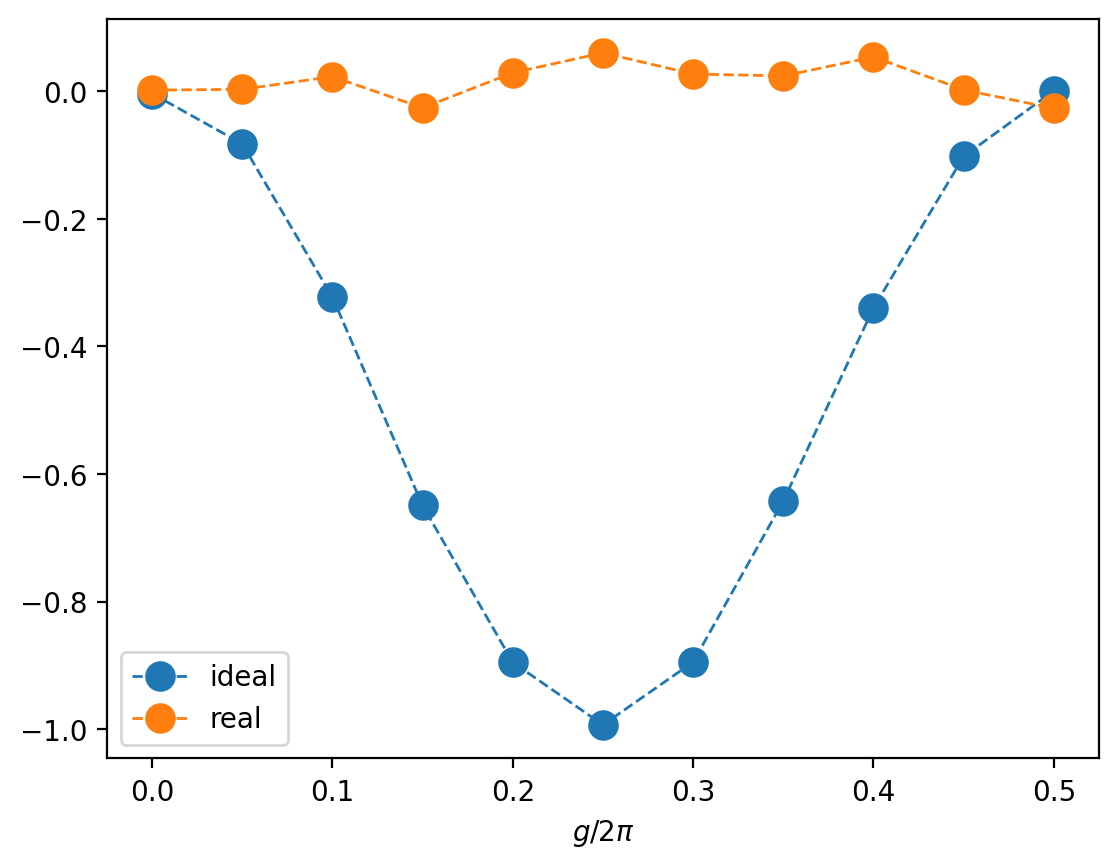

In [15]:
fig, ax = plt.subplots()
ax.plot(g_vals/(2*np.pi), ideal_expval, 'o--', ms=10, lw=1, label='ideal')
ax.plot(g_vals/(2*np.pi), real_expval, 'o--', ms=10, lw=1, label='real')
ax.legend()
ax.set_xlabel('$g/2\pi$');

## Adding Dynamical Decoupling Sequence

To begin, we need a few things. First, we need to ask the backend for durations of all of its supported instructions. Second, we need to understand the constraints on timing enforced by the target hardware

![cpmg_sequence-2.svg](imgs/cpmg_sequence.svg)

In [14]:
durations = InstructionDurations.from_backend(backend)
constraints = backend.configuration().timing_constraints
# durations = fake_backend.instruction_durations() # fake-backend
# constraints = fake_backend.target.timing_constraints() # fake-backend

In [15]:
constraints

{'acquire_alignment': 8,
 'granularity': 8,
 'min_length': 16,
 'pulse_alignment': 8}

We are now in a position to select the DD gate sequence that we want to use. Here, we will will look at the simple CPMG sequence. Constructing this sequence requires actual gate instances imported from the Qiskit circuit library

In [16]:
# CPMG sequence
dd_sequence = [XGate(), XGate()]
# Fraction of duration to place in-between DD sequence gates
spacing = [1 / 4, 1 / 2, 1 / 4]

### DD PassManager

Inserting this sequence into our circuits requires using a `PassManager`. A `PassManager` is an object that governs how circuits get transformed into new circuits. For example, every time an user calls `transpile`, a `PassManager` is created internally that performs all of the gate transformations, qubit routing, and optimization that is being done.

`PassManager`s work by executing many basic operations that are defined by “passes”. Each pass does something simple with a given circuit. Some passes analyze circuits, others take that information and use it to perform transformations, e.g. taking an input circuit and expressing it in the basis gate set of the target system. Qiskit supports many different types of analysis and transformation passes, and their usage is beyond the scope of this notebook.

It turns out that we need just a few items. First, we need an analysis pass that looks at timing information for ALAP scheduling. This is the `ALAPScheduleAnalysis` pass. We can then apply the `PadDynamicalDecoupling` pass that does the actual gate insertion at the approprate times. These can be added, in order, to a `PassManager`:

In [17]:
pm = PassManager([ALAPScheduleAnalysis(durations),
                  PadDynamicalDecoupling(
                      durations,
                      dd_sequence,
                      spacing=spacing,
                      pulse_alignment=constraints['pulse_alignment']
                  )
                ])

In [18]:
dd_circs = pm.run(trans_circs)

### Results with Dynamical Decoupling

In [21]:
dd_counts = backend.run(dd_circs, shots=shots).result().get_counts()

In [22]:
dd_expval = [sampled_expectation_value(dist=cnts, oper=operator) for cnts in dd_counts]

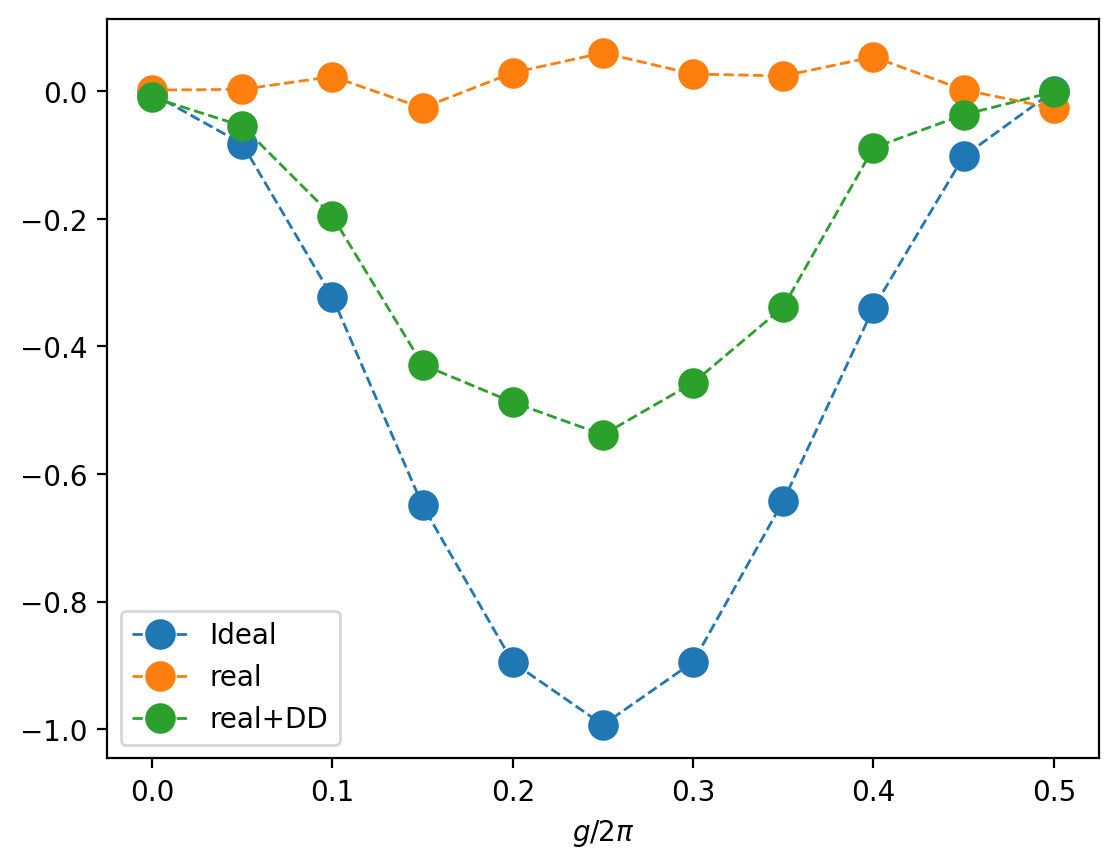

In [23]:
fig, ax = plt.subplots()
ax.plot(g_vals/(2*np.pi), ideal_expval, 'o--', ms=10, lw=1, label='Ideal')
ax.plot(g_vals/(2*np.pi), real_expval, 'o--', ms=10, lw=1, label='real')
ax.plot(g_vals/(2*np.pi), dd_expval, 'o--', ms=10, lw=1, label='real+DD')
ax.legend()
ax.set_xlabel('$g/2\pi$');

In [20]:
import numpy
print(f"numpy version {numpy.__version__}")

import qiskit_ibm_runtime
print(f"qiskit runtime version {qiskit_ibm_runtime.version.get_version_info()}")

import qiskit.tools.jupyter
%qiskit_version_table

numpy version 1.23.5
qiskit runtime version 0.13.0
